In [3]:
import os, sys
import numpy as np
from astropy import units
from astropy.io import fits
from astropy.time import Time
from astropy.table import Table
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d

### HARPS-N spectra

In [246]:
harps_directory = '/Users/arcticfox/Documents/AUMic/harps-n/'
harps_files = np.sort([os.path.join(harps_directory, i) for i in 
                       os.listdir(harps_directory) if i.endswith('.fits')])

In [247]:
harps_data_cube = np.full((3, len(harps_files), 400000), np.nan)

for i in range(len(harps_files)):
    hdu = fits.open(harps_files[i])
    l = len(hdu[1].data[0]['WAVE'])
    harps_data_cube[0][i][:l] = hdu[1].data[0]['WAVE']+0.0
    harps_data_cube[1][i][:l] = hdu[1].data[0]['FLUX']+0.0
    harps_data_cube[2][i][:l] = hdu[1].data[0]['ERR']+0.0
    hdu.close()

In [248]:
# Need to interpolate onto the same wavelength grid to combine
start = np.nanmax(harps_data_cube[0][:,0])

es = np.zeros(len(harps_files))
for i in range(len(harps_files)):
    q = np.isnan(harps_data_cube[0][i])==False
    es[i] = harps_data_cube[0][i][q][-1]
end = np.nanmin(es)

In [249]:
harps_wavelength = np.flip(np.logspace(np.log10(end), np.log10(start), 310000))[1:-1]

In [254]:
harps_spectra = np.zeros((len(harps_files), len(harps_wavelength)))
for i in range(len(harps_files)):
    interp = interp1d(harps_data_cube[0][i], harps_data_cube[1][i])
    harps_spectra[i] = interp(harps_wavelength)
#harps_spectra = np.nanmedian(harps_spectra, axis=0)

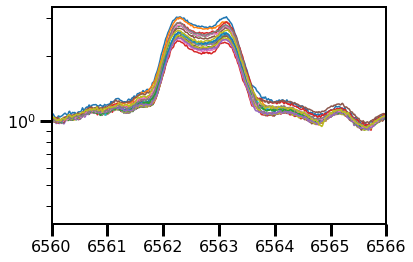

In [269]:
for i in range(len(harps_spectra)):
    q = (harps_wavelength > 6545) & (harps_wavelength < 6580)
    plt.plot(harps_wavelength[q], harps_spectra[i][q]/np.nanmedian(harps_spectra[i][q]))
plt.xlim(6560,6566)
plt.yscale('log')

In [128]:
np.save('harps_spectra.npy', [harps_wavelength, harps_spectra])

### FUSE spectra

In [379]:
fuse_directory = '/Users/arcticfox/Documents/AUMic/fuse/'
fuse_files = np.sort(np.unique([os.path.join(fuse_directory, i) for i in 
                      os.listdir(fuse_directory) if i.endswith('ttagfcal.fit')]))
#fuse_spectra_files = np.array([fuse_files[0],fuse_files[10]])
#fuse_files = np.delete(fuse_files,[0,10])

In [433]:
fuse_wave_cube = np.zeros((4, 44, 30000))
fuse_flux_cube = np.zeros((4, 44, 30000))

tags = ['alif', 'asic', 'blif', 'bsic']

times = np.zeros((4,44,2), dtype='U40')

for j in range(len(tags)):
    ff = np.sort([i for i in fuse_files if tags[j] in i])

    for i in range(len(ff)):
        hdu = fits.open(ff[i])
        t = hdu[0].header['EXPSTART']

        times[j][i][0] = str(Time(hdu[0].header['EXPSTART'], format='mjd').datetime)
        times[j][i][1] = str(Time(hdu[0].header['EXPEND'], format='mjd').datetime)

        fuse_wave_cube[j][i][:len(hdu[1].data['WAVE'])] = hdu[1].data['WAVE']
        fuse_flux_cube[j][i][:len(hdu[1].data['FLUX'])] = hdu[1].data['FLUX']

        hdu.close()

In [464]:
inds = [[0,18],[1,19]]

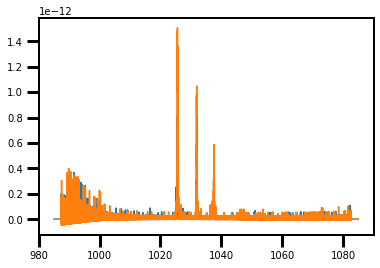

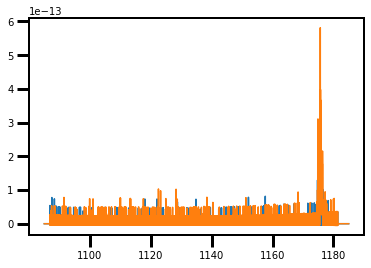

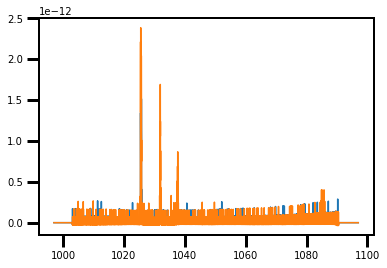

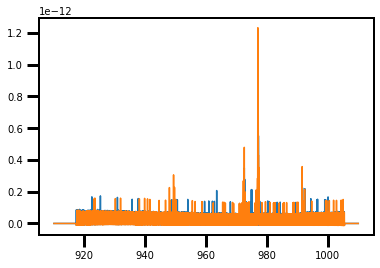

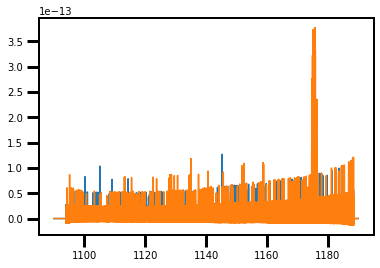

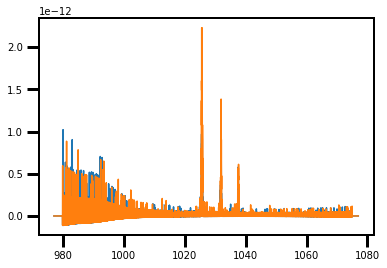

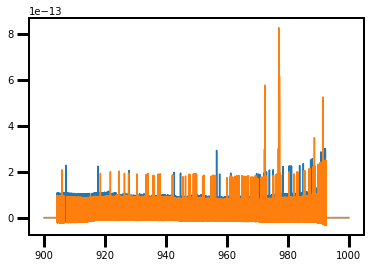

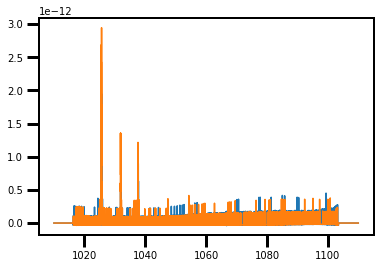

In [527]:
interp_wave = np.zeros((4,4,7700-2))
interp_flux = np.zeros((4,4,7700-2))

for j in range(len(tags)):
    w, f = [], []
    minw, maxw = [], []
    
    for i in range(len(inds)):
        q = fuse_wave_cube[j][inds[i][0]]>0
        plt.plot(fuse_wave_cube[j][inds[i][0]][q], fuse_flux_cube[j][inds[i][0]][q])
        w.append(fuse_wave_cube[j][inds[i][0]][q])
        f.append(fuse_flux_cube[j][inds[i][0]][q])
        
        minw.append(np.nanmin(fuse_wave_cube[j][inds[i][0]][q]))
        maxw.append(np.nanmax(fuse_wave_cube[j][inds[i][0]][q]))
        
        q = fuse_wave_cube[j][inds[i][1]]>0 
        plt.plot(fuse_wave_cube[j][inds[i][1]][q], fuse_flux_cube[j][inds[i][1]][q])
        w.append(fuse_wave_cube[j][inds[i][1]][q])
        f.append(fuse_flux_cube[j][inds[i][1]][q])
        plt.show()
    
        minw.append(np.nanmin(fuse_wave_cube[j][inds[i][1]][q]))
        maxw.append(np.nanmax(fuse_wave_cube[j][inds[i][1]][q]))
    
    neww1 = np.logspace(np.log10(np.nanmax(minw[:2])), 
                        np.log10(np.nanmin(maxw[:2])), 7700)[1:-1]
    neww2 = np.logspace(np.log10(np.nanmax(minw[2:])), 
                        np.log10(np.nanmin(maxw[2:])), 7700)[1:-1]
    
    for i in range(len(w)):
        itrp = interp1d(w[i], f[i])
        if i < 2:
            interp_wave[j][i] = neww1
            interp_flux[j][i] = itrp(neww1)
        else:
            interp_wave[j][i] = neww2
            interp_flux[j][i] = itrp(neww2)

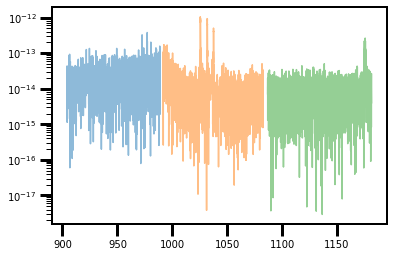

In [565]:
finalw, finalf = np.array([]), np.array([])

for i in [3,0]:
    q = np.nanmean(interp_flux[i][:2],axis=0)>0
    if i == 0:
        cutends = 130
        plt.plot(interp_wave[i][0][q][cutends:], 
                 np.nanmean(interp_flux[i][:2],axis=0)[q][cutends:],
                 alpha=0.5)
        finalw = np.append(finalw, interp_wave[i][0][q][cutends:])
        finalf = np.append(finalf, np.nanmean(interp_flux[i][:2],axis=0)[q][cutends:])
    else:
        cutends=130
        plt.plot(interp_wave[i][0][q][:-cutends], 
                 np.nanmean(interp_flux[i][:2],axis=0)[q][:-cutends],
                 alpha=0.5)
        finalw = np.append(finalw, interp_wave[i][0][q][:-cutends])
        finalf = np.append(finalf, np.nanmean(interp_flux[i][:2],axis=0)[q][:-cutends])    
    if i != 3:
        q = np.nanmean(interp_flux[i][2:],axis=0)>0
        plt.plot(interp_wave[i][2][q], np.nanmean(interp_flux[i][2:],axis=0)[q],alpha=0.5)
        
        finalw = np.append(finalw, interp_wave[i][2][q])
        finalf = np.append(finalf, np.nanmean(interp_flux[i][2:],axis=0)[q])
        
plt.yscale('log')
plt.show()

In [568]:
np.save('fuse_spectra.npy', [finalw, finalf])

### XMM spectra

In [5]:
plt.rcParams['font.size'] = 16

In [6]:
obsIDs = ['obsID0822740401', 'obsID0822740601']# 'obsID0822740501']
xmm_directory = '/Users/arcticfox/Documents/AUMic/xmm_spectra/{0}_{1}'

#### XMM light curves & flare IDing

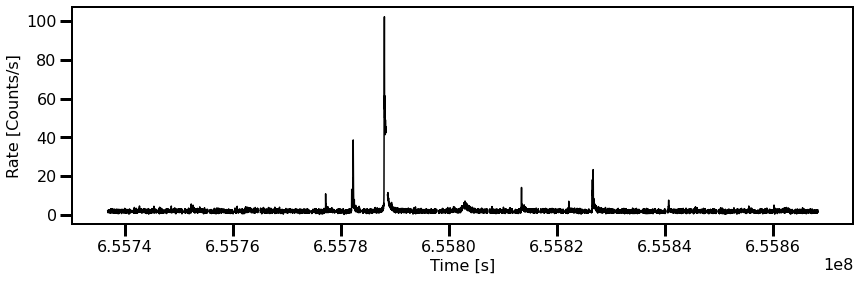

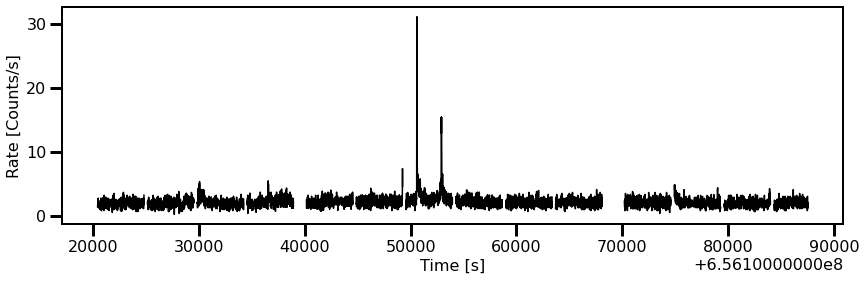

In [44]:
lc_tref = np.zeros((len(obsIDs), 200, 2))
lc_time, lc_rate = np.zeros(len(obsIDs), dtype=np.ndarray), np.zeros(len(obsIDs), dtype=np.ndarray)

for d in range(len(obsIDs)):
    fig=plt.figure(figsize=(14,4))
    fig.set_facecolor('w')
    
    xmm_lc_files = np.sort([os.path.join(xmm_directory.format(obsIDs[d], 'lcs'),i) for i in 
                        os.listdir(xmm_directory.format(obsIDs[d],'lcs'))
                     if i.endswith('FTZ') and 'TIMESR' in i])
    
    for i in range(len(xmm_lc_files)):
        hdu = fits.open(xmm_lc_files[i])

        plt.plot(hdu[1].data['TIME'], hdu[1].data['RATE'],'k')
        sr = Time(hdu[1].header['MJDREF'],format='mjd')+(hdu[1].header['TSTART']*units.s)
        sp = Time(hdu[1].header['MJDREF'],format='mjd')+(hdu[1].header['TSTOP']*units.s)
        
        lc_time[d] = np.append(lc_time[d], hdu[1].data['TIME'])
        lc_rate[d] = np.append(lc_rate[d], hdu[1].data['RATE']- hdu[1].data['BACKV'])
        lc_tref[d][i] = [sr.mjd, sp.mjd]
        
        hdu.close()
    plt.xlabel('Time [s]')
    plt.ylabel('Rate [Counts/s]')
    plt.show()

In [42]:
lc_tref

array([[[58403.54689805, 58403.59770824],
        [58403.6013761 , 58403.65218628],
        [58403.65585612, 58403.70666631],
        [58403.7103566 , 58403.76116678],
        [58403.76484617, 58403.81565636],
        [58403.81929652, 58403.8701067 ],
        [58403.87377568, 58403.92458587],
        [58403.92824315, 58403.97905334],
        [58403.98274407, 58404.03355425],
        [58404.03720999, 58404.08802017],
        [58404.09170046, 58404.14251064],
        [58404.14617978, 58404.19698997],
        [58404.20064716, 58404.25145734],
        [58404.25513772, 58404.3059479 ],
        [58404.30962603, 58404.36043621],
        [58404.36409384, 58404.41490402],
        [58404.41857358, 58404.46938376],
        [58404.47305072, 58404.52386091],
        [58404.52755234, 58404.57836252],
        [58404.58200776, 58404.63281794],
        [58404.63648641, 58404.6872966 ],
        [58404.69096517, 58404.74177536],
        [58404.74543187, 58404.79624206],
        [58404.7999169 , 58404.850

In [40]:
Time(hdu[1].header['MJDREF'], format='mjd')+(hdu[1].header['EXPOSURE']*units.s)

<Time object: scale='utc' format='mjd' value=50814.03726851852>

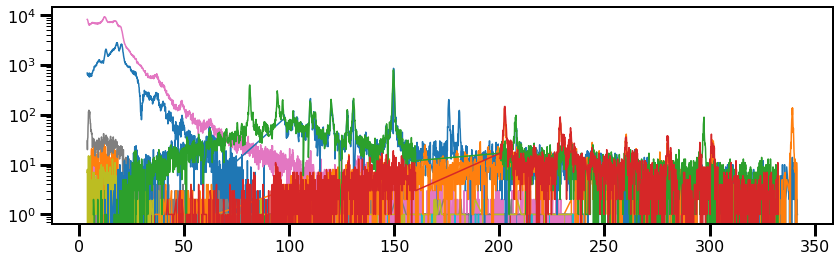

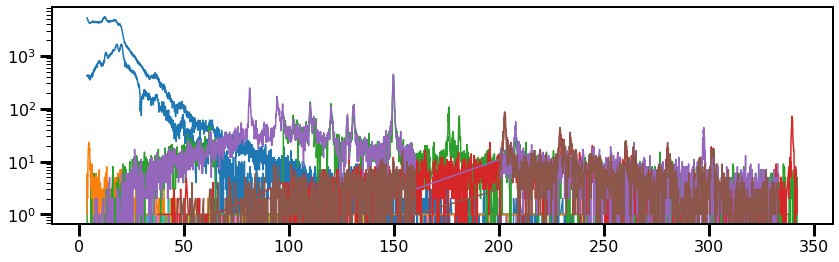

In [51]:
tmid_spec = np.zeros((len(obsIDs),100,2))
counts, channel = np.zeros(len(obsIDs), dtype=np.ndarray), np.zeros(len(obsIDs), dtype=np.ndarray)
texp = np.zeros(len(obsIDs), dtype=np.ndarray)
area = 150 * units.cm**2

for d in range(len(obsIDs)):
    
    xmm_sp_files = np.sort([os.path.join(xmm_directory.format(obsIDs[d],'spectra'),i) for i in 
                        os.listdir(xmm_directory.format(obsIDs[d],'spectra'))
                     if i.endswith('FTZ') and 'SRSPEC' in i])
    xmm_bg_files = np.sort([os.path.join(xmm_directory.format(obsIDs[d],'spectra'),i) for i in 
                        os.listdir(xmm_directory.format(obsIDs[d],'spectra'))
                     if i.endswith('FTZ') and 'BGSPEC' in i])
    
    fig=plt.figure(figsize=(14,4))
    bad = np.array([], dtype=int)
    
    for i in range(len(xmm_sp_files)):
        spec = fits.open(xmm_sp_files[i])
        bkg  = fits.open(xmm_bg_files[i])
        
        texp[d] = np.append(texp[d], spec[1].header['EXPOSURE'])
        #sr = Time(spec[0].header['MJDREF'],format='mjd')+(spec[0].header['TSTART']*units.s)
        #sp = Time(spec[0].header['MJDREF'],format='mjd')+(spec[0].header['TSTOP']*units.s)
        
        #tmid_spec[d][i] = [sr.mjd, sp.mjd]
        
        if i == 0:
            temp_chan = np.zeros((len(xmm_sp_files), len(spec[1].data['CHANNEL'])))
            temp_cnts  = np.zeros((len(xmm_sp_files), 
                                   len(spec[1].data['COUNTS']- bkg[1].data['COUNTS'])))
            
        try:
            temp_chan[i] = spec[1].data['CHANNEL']/10
            temp_cnts[i]  = (spec[1].data['COUNTS']- bkg[1].data['COUNTS'])#/(area*texp)
        except:
            bad = np.append(bad, i)
            pass
        
        q = spec[1].data['COUNTS'] > 0
        plt.plot(spec[1].data['CHANNEL'][q]/10, 
                 (spec[1].data['COUNTS'][q]- bkg[1].data['COUNTS'][q]))#/(area*texp[d][i]))
        spec.close()
    plt.yscale('log')
    plt.show()
    
    channel[d] = np.delete(temp_chan, bad, axis=0)
    counts[d]  = np.delete(temp_cnts, bad, axis=0)
    texp[d]    = np.delete(texp[d], bad, axis=0)
#plt.savefig('/Users/arcticfox/Desktop/xmm_lc.png', dpi=250, rasterize=True, bbox_inches='tight')

In [30]:
np.save('xmm_spec.npy', {'flux':counts,
                         'channel':channel,
                        'tsteps':tmid_spec})
np.save('xmm_lc.npy', {'time':lc_time,
                         'rate':lc_rate,
                      'tsteps':lc_tref})

### IUE NUV spectra

In [129]:
iue_path = '/Users/arcticfox/Documents/AUMic/iue/'
iue_files = np.sort([os.path.join(iue_path, i) for i in os.listdir(iue_path)
                     if i.endswith('.mxlo') and 'lwp' in i])

(1e-14, 1e-12)

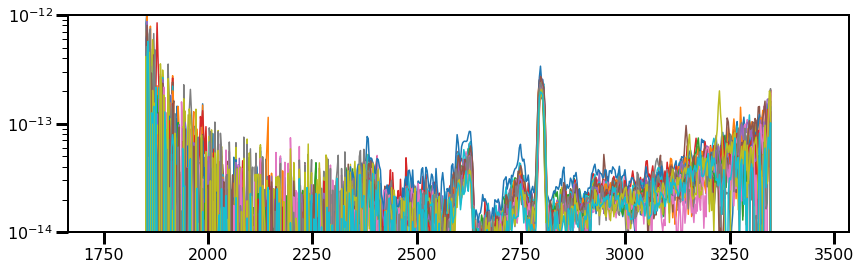

In [136]:
plt.figure(figsize=(14,4))
iue_wave, iue_flux = np.zeros((len(iue_files), 640)), np.zeros((len(iue_files), 640))
iue_qual = np.zeros((len(iue_files), 640))

for i in range(len(iue_files)):
    hdu=fits.open(iue_files[i])
    q = hdu[1].data['QUALITY'][0] == 0

    plt.plot(np.arange(hdu[1].data['WAVELENGTH'], 3452, hdu[1].data['DELTAW']),
                 hdu[1].data['FLUX'][0])

    iue_wave[i] = np.arange(hdu[1].data['WAVELENGTH'], 3452, hdu[1].data['DELTAW'])
    iue_flux[i] = hdu[1].data['FLUX'][0] + 0.0
    iue_qual[i] = hdu[1].data['QUALITY'][0] + 0.0
    
    hdu.close()
plt.yscale('log')
plt.ylim(10e-15, 10e-13)

In [137]:
np.save('iue_spectra.npy', [iue_wave, iue_flux, iue_qual])

In [140]:
all_good = np.nansum(iue_qual,axis=0)

In [141]:
iue_med_wave = np.nanmedian(iue_wave, axis=0)[all_good==0]
iue_med_flux = np.nanmedian(iue_flux, axis=0)[all_good==0]

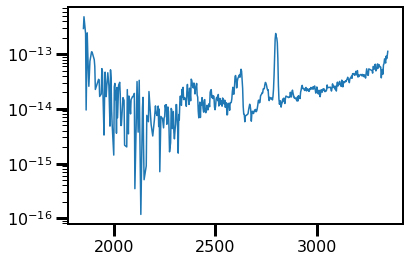

In [144]:
q = iue_med_flux > 0
plt.plot(iue_med_wave[q], iue_med_flux[q])
plt.yscale('log')

# Plot all together

In [147]:
dpath = '/Users/arcticfox/Documents/GitHub/cos_flares/data/'
harps_wavelength, harps_spectra = np.load(os.path.join(dpath,'harps_spectra.npy'), 
                                          allow_pickle=True)

cos_quiescent = Table.read(os.path.join(dpath,'quiescent_feinstein.txt'),format='csv')
cos_flare = Table.read(os.path.join(dpath,'flareB_feinstein.txt'),format='csv')

fuse_wavelength, fuse_spectra = np.load(os.path.join(dpath,'fuse_spectra.npy'), 
                                        allow_pickle=True)

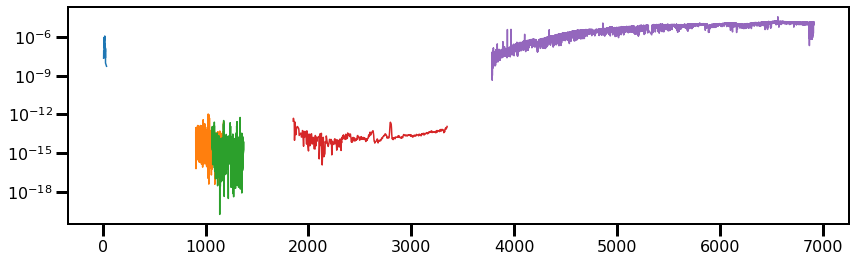

In [245]:
fig = plt.figure(figsize=(14,4))

xmm_sp = np.nanmean(counts[0],axis=0)/(area*np.nanmax(texp[0])*units.s)
q = xmm_sp > 0
plt.plot(np.nanmedian(channel[0],axis=0)[q], xmm_sp[q])

q = fuse_spectra>0
plt.plot(fuse_wavelength[q], fuse_spectra[q])

q = cos_quiescent['flux_density']>0
plt.plot(cos_quiescent['wavelength_AA'][q], cos_quiescent['flux_density'][q])

q = iue_med_flux > 0
plt.plot(iue_med_wave[q], iue_med_flux[q])

q = harps_spectra>0
plt.plot(harps_wavelength[q], harps_spectra[q]/10e8)

plt.yscale('log')
plt.show()